In [1]:
from torch.nn.functional import cosine_similarity
import torch as th
import numpy as np
import pandas as pd
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

th.set_grad_enabled(False)

In [2]:
device = "cuda"

In [3]:
import numpy as np
if not hasattr(np, "bool"):
    np.bool = bool 

/tmp/ipykernel_1633991/1319403643.py:2: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "bool"):


In [4]:
import json

In [5]:
def load_dictionary_model(
    model_name: str | Path, is_sae: bool | None = None,
):
    """Load a dictionary model from a local path or HuggingFace Hub.

    Args:
        model_name: Name or path of the model to load

    Returns:
        The loaded dictionary model
    """
    # Check if it's a HuggingFace Hub model
    if "/" not in str(model_name) or not Path(model_name).exists():
        # Legacy model
        if str(model_name) in df_hf_repo_legacy:
            model_name = df_hf_repo_legacy[str(model_name)]
        else:
            model_name = str(model_name)
        if "/" not in str(model_name):
            model_id = f"{author}/{str(model_name)}"
        else:
            model_id = model_name
        # Download config to determine model type
        if file_exists(model_id, "trainer_config.json", repo_type="model"):
            config_path = hf_hub_download(
                repo_id=model_id, filename="trainer_config.json"
            )
            with open(config_path, "r") as f:
                config = json.load(f)["trainer"]

            # Determine model class based on config
            if "dict_class" in config and config["dict_class"] in [
                "BatchTopKSAE",
                "CrossCoder",
                "BatchTopKCrossCoder",
            ]:
                return eval(
                    f"{config['dict_class']}.from_pretrained(model_id, from_hub=True)"
                )
            else:
                raise ValueError(f"Unknown model type: {config['dict_class']}")
        else:
            logger.info(
                f"No config found for {model_id}, relying on is_sae={is_sae} arg to determine model type"
            )
            # If no model_type in config, try to infer from other fields
            if is_sae:
                return BatchTopKSAE.from_pretrained(model_id, from_hub=True)
            else:
                return CrossCoder.from_pretrained(model_id, from_hub=True)
    else:
        # Local model
        model_path = Path(model_name)
        if not model_path.exists():
            raise ValueError(f"Local model {model_name} does not exist")

        # Load the config
        with open(model_path.parent / "config.json", "r") as f:
            config = json.load(f)["trainer"]

        # Determine model class based on config
        if "dict_class" in config and config["dict_class"] in [
            "BatchTopKSAE",
            "CrossCoder",
            "BatchTopKCrossCoder",
        ]:
            return eval(f"{config['dict_class']}.from_pretrained(model_path)")
        else:
            raise ValueError(f"Unknown model type: {config['dict_class']}")


In [6]:
from dictionary_learning.dictionary import BatchTopKCrossCoder, CrossCoder

In [19]:
coder = load_dictionary_model("/pscratch/sd/r/ritesh11/temp_dir/crosscoder_checkpoints/Qwen3-1.7B-L20-k100-lr1e-04-ep2-run_1-Crosscoder/checkpoint_90000.pt")

In [20]:
base_layer, instruct_layer = 0,1 

In [21]:
df = pd.read_csv("latent_df.csv")

In [22]:
deads = (df.frequencies_true.values == 0) & (df.frequencies_false.values == 0)

In [23]:
num_layers, activation_dim, dict_size = coder.encoder.weight.shape
alive_mask = ~deads

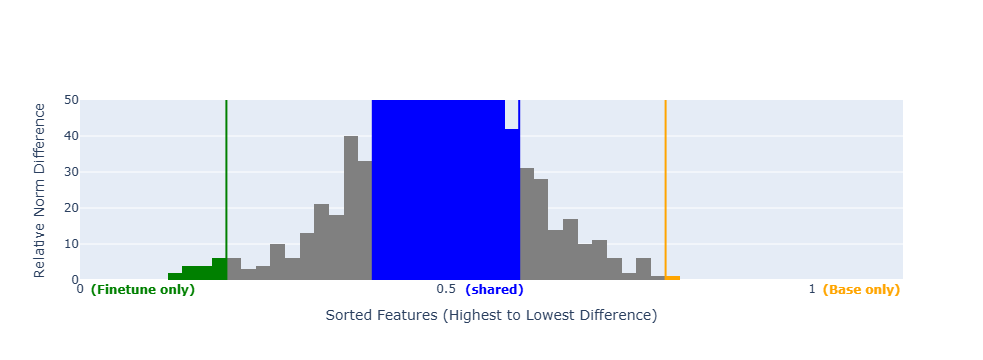

In [40]:
# Create masks for each category
finetune_only_mask = norm_diffs[alive_mask] <= 0.2
base_only_mask = norm_diffs[alive_mask] >= 0.8
shared_mask = (0.4 <= norm_diffs[alive_mask]) & (norm_diffs[alive_mask] <= 0.6)
other_mask = ~(finetune_only_mask | base_only_mask | shared_mask)

# Create figure
fig = go.Figure()

# Add histogram traces for each category
fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][finetune_only_mask],
        name="Finetune only",
        marker_color="green",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][base_only_mask],
        name="Base only",
        marker_color="orange",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][shared_mask],
        name="Shared",
        marker_color="blue",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][other_mask],
        name="Other",
        marker_color="grey",
        nbinsx=50,
    )
)

fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Finetune only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="green"),
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="    <b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="blue"),
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="orange"),
        ),
    ],
    shapes=[
        dict(  # Finetune threshold
            type="line",
            x0=0.2,
            y0=0,
            x1=0.2,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="green", width=2),
        ),
        dict(  # Base threshold
            type="line",
            x0=0.8,
            y0=0,
            x1=0.8,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="orange", width=2),
        ),
        dict(  # Shared lower
            type="line",
            x0=0.4,
            y0=0,
            x1=0.4,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="blue", width=2),
        ),
        dict(  # Shared upper
            type="line",
            x0=0.6,
            y0=0,
            x1=0.6,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="blue", width=2),
        ),
    ],
    showlegend=False,
)

fig.update_xaxes(tickvals=[0, 0.5, 1])
fig.update_xaxes(title="Sorted Features (Highest to Lowest Difference)")
fig.update_yaxes(title="Relative Norm Difference", range=[0, 50])
fig.update_layout(barmode="stack")
fig.show()

In [43]:
df['dec_norm_diffs'] = norm_diffs

In [47]:
conditions = [
    df["dec_norm_diffs"] <= 0.2,
    (df["dec_norm_diffs"] >= 0.4) & (df["dec_norm_diffs"] <= 0.6),
    df["dec_norm_diffs"] >= 0.8,
]
choices = ["Finetune_only", "Shared", "Base_only"]

df["latent_tag"] = np.select(conditions, choices, default="Other")

In [52]:
df.to_csv('latent_df.csv',index=False)

In [39]:
(norm_diffs < 0.2).sum()

tensor(16)

In [ ]:
enc_norms = coder.encoder.weight.norm(dim=1)
enc_norm_diffs = (
    (enc_norms[base_layer] - enc_norms[instruct_layer]) / enc_norms.max(dim=0).values
    + 1
) / 2



fig = px.histogram(
    x=enc_norm_diffs[~deads],
    title="Relative difference in encoder dead feature norms",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Relative Norm Difference")
fig.update_yaxes(title="Count")
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Chat only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
    ]
)
fig.update_yaxes(title="Relative Norm Difference", range=[0, 50])
fig.show()

In [32]:
norm_diff

tensor(0.5026)